# Training an FNO on Navier-Stokes

> Based on `neuraloperator/scripts/train_navier_stokes.py`, see Li et al. (2020).

> Note that the neuralop built-in Navier Stokes dataset is only taken at 1 time step






In [1]:
# load packages

import torch
import matplotlib.pyplot as plt
import sys
import wandb
from neuralop.models import FNO
from neuralop import Trainer
from neuralop.training import AdamW
from neuralop.data.datasets import load_navier_stokes_pt
from neuralop.utils import count_model_params
from neuralop import LpLoss, H1Loss
from pathlib import Path

device = 'cpu'

Loading test db for resolution 128 with 50 samples 
Training set - x shape:torch.Size([1, 128, 128])
Training set - y shape:torch.Size([1, 128, 128])
Test set - x shape:torch.Size([1, 128, 128])
Test set - y shape:torch.Size([1, 128, 128])


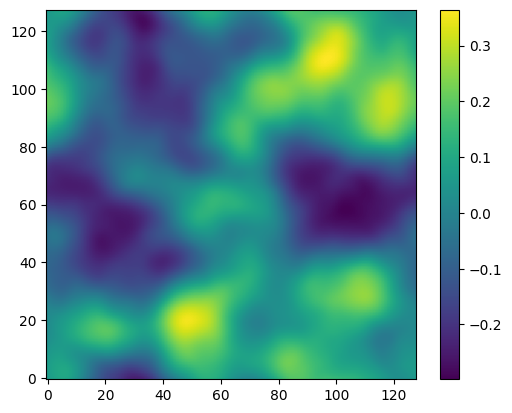

In [6]:
# load data
data_dir = Path("../data/navier_stokes")
train_loader, test_loaders, data_processor = load_navier_stokes_pt(
    data_root=data_dir,
    train_resolution=128,
    n_train=1000,
    batch_size=8,
    test_resolutions=[128],
    n_tests=[50],
    test_batch_sizes=[8],
    encode_input=True,
    encode_output=True,
)
data_processor = data_processor.to(device)

train_dataset = train_loader.dataset # [id_data, 'x'/'y', [channels,width,height]]
test_dataset = test_loaders[128].dataset

print(f"Training set - x shape:{train_dataset[0]['x'].shape}")
print(f"Training set - y shape:{train_dataset[0]['y'].shape}")
print(f"Test set - x shape:{test_dataset[0]['x'].shape}")
print(f"Test set - y shape:{test_dataset[0]['y'].shape}")

# have a look
plt.imshow(train_dataset[0]['x'][0, :, :], origin="lower")
plt.colorbar()
plt.show()

In [7]:
# config model
model = FNO(
    n_modes=(16,16),
    in_channels=1,
    out_channels=1,
    hidden_channels=32,
    projection_channel_ratio=2
)
model = model.to(device)
data_processor = data_processor.to(device)

n_params = count_model_params(model)
print(f'\nOur model has {n_params} parameters.')
sys.stdout.flush()


Our model has 1192801 parameters.


In [8]:
# training setup
optimizer = AdamW(
    model.parameters(),
    lr=3e-4, # learning rate
    weight_decay=1e-4
)

# use StepLR scheduler
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer, step_size=100, gamma=0.5
)

# losses setup
l2loss = LpLoss(d=2, p=2)
h1loss = H1Loss(d=2)

train_loss = h1loss # use H1 loss
eval_losses = {'h1': h1loss, 'l2':l2loss}

print('\n### MODEL ###\n', model)
print('\n### OPTIMIZER ###\n', optimizer)
print('\n### SCHEDULER ###\n', scheduler)
print('\n### LOSSES ###')
print(f'\n * Train: {train_loss}')
print(f'\n * Test: {eval_losses}')
sys.stdout.flush()



### MODEL ###
 FNO(
  (positional_embedding): GridEmbeddingND()
  (fno_blocks): FNOBlocks(
    (convs): ModuleList(
      (0-3): 4 x SpectralConv(
        (weight): DenseTensor(shape=torch.Size([32, 32, 16, 9]), rank=None)
      )
    )
    (fno_skips): ModuleList(
      (0-3): 4 x Flattened1dConv(
        (conv): Conv1d(32, 32, kernel_size=(1,), stride=(1,), bias=False)
      )
    )
    (channel_mlp): ModuleList(
      (0-3): 4 x ChannelMLP(
        (fcs): ModuleList(
          (0): Conv1d(32, 16, kernel_size=(1,), stride=(1,))
          (1): Conv1d(16, 32, kernel_size=(1,), stride=(1,))
        )
      )
    )
    (channel_mlp_skips): ModuleList(
      (0-3): 4 x SoftGating()
    )
  )
  (lifting): ChannelMLP(
    (fcs): ModuleList(
      (0): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
      (1): Conv1d(64, 32, kernel_size=(1,), stride=(1,))
    )
  )
  (projection): ChannelMLP(
    (fcs): ModuleList(
      (0): Conv1d(32, 64, kernel_size=(1,), stride=(1,))
      (1): Conv1d(64, 

In [11]:
# %%capture training_output
# create the trainer
trainer = Trainer(
    model=model,
    n_epochs=50,
    data_processor=data_processor,
    device=device,
    mixed_precision=False,
    eval_interval=1,
    log_output=True,
    use_distributed=False,
    verbose=True,
    wandb_log = False
)

# train
trainer.train(
    train_loader=train_loader,
    test_loaders=test_loaders,
    optimizer=optimizer,
    scheduler=scheduler,
    regularizer=False,
    training_loss=train_loss,
    eval_losses=eval_losses,
    save_every=10,
    save_dir="./ckpt/"
)

# with open("./training_log.txt", "w") as f:
#     f.write(training_output.stdout)

Training on 1000 samples
Testing on [50] samples         on resolutions [128].
Raw outputs of shape torch.Size([8, 1, 128, 128])
[0] time=44.87, avg_loss=0.2001, train_err=1.6008
Eval: 128_h1=0.2219, 128_l2=0.0807
[Rank 0]: saved training state to ./ckpt/
[1] time=50.47, avg_loss=0.1979, train_err=1.5834
Eval: 128_h1=0.2200, 128_l2=0.0800
[2] time=53.63, avg_loss=0.1958, train_err=1.5665
Eval: 128_h1=0.2181, 128_l2=0.0794
[3] time=50.08, avg_loss=0.1938, train_err=1.5503
Eval: 128_h1=0.2163, 128_l2=0.0788
[4] time=47.20, avg_loss=0.1919, train_err=1.5348
Eval: 128_h1=0.2145, 128_l2=0.0782
[5] time=48.35, avg_loss=0.1900, train_err=1.5200
Eval: 128_h1=0.2129, 128_l2=0.0776
[6] time=48.27, avg_loss=0.1882, train_err=1.5057
Eval: 128_h1=0.2113, 128_l2=0.0771
[7] time=48.72, avg_loss=0.1865, train_err=1.4919
Eval: 128_h1=0.2098, 128_l2=0.0765
[8] time=49.45, avg_loss=0.1848, train_err=1.4787
Eval: 128_h1=0.2083, 128_l2=0.0760
[9] time=45.19, avg_loss=0.1832, train_err=1.4660
Eval: 128_h1=0

{'train_err': 1.1629729781150817,
 'avg_loss': 0.14537162226438521,
 'avg_lasso_loss': None,
 'epoch_train_time': 44.97163730000102,
 '128_h1': tensor(0.1766),
 '128_l2': tensor(0.0635),
 '128_outputs': <wandb.sdk.data_types.image.Image at 0x23e65e718b0>}

In [24]:
# save model
print(model)
torch.save(model.state_dict(), "./model/fno.pt")

FNO(
  (positional_embedding): GridEmbeddingND()
  (fno_blocks): FNOBlocks(
    (convs): ModuleList(
      (0-3): 4 x SpectralConv(
        (weight): DenseTensor(shape=torch.Size([32, 32, 16, 9]), rank=None)
      )
    )
    (fno_skips): ModuleList(
      (0-3): 4 x Flattened1dConv(
        (conv): Conv1d(32, 32, kernel_size=(1,), stride=(1,), bias=False)
      )
    )
    (channel_mlp): ModuleList(
      (0-3): 4 x ChannelMLP(
        (fcs): ModuleList(
          (0): Conv1d(32, 16, kernel_size=(1,), stride=(1,))
          (1): Conv1d(16, 32, kernel_size=(1,), stride=(1,))
        )
      )
    )
    (channel_mlp_skips): ModuleList(
      (0-3): 4 x SoftGating()
    )
  )
  (lifting): ChannelMLP(
    (fcs): ModuleList(
      (0): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
      (1): Conv1d(64, 32, kernel_size=(1,), stride=(1,))
    )
  )
  (projection): ChannelMLP(
    (fcs): ModuleList(
      (0): Conv1d(32, 64, kernel_size=(1,), stride=(1,))
      (1): Conv1d(64, 1, kernel_size=(

In [26]:
# test reloading model
model_reload = FNO(
    n_modes=(16,16),
    in_channels=1,
    out_channels=1,
    hidden_channels=32,
    projection_channel_ratio=2
)
model_reload.load_state_dict(torch.load("./model/fno.pt", weights_only=False))
model_reload.eval()

FNO(
  (positional_embedding): GridEmbeddingND()
  (fno_blocks): FNOBlocks(
    (convs): ModuleList(
      (0-3): 4 x SpectralConv(
        (weight): DenseTensor(shape=torch.Size([32, 32, 16, 9]), rank=None)
      )
    )
    (fno_skips): ModuleList(
      (0-3): 4 x Flattened1dConv(
        (conv): Conv1d(32, 32, kernel_size=(1,), stride=(1,), bias=False)
      )
    )
    (channel_mlp): ModuleList(
      (0-3): 4 x ChannelMLP(
        (fcs): ModuleList(
          (0): Conv1d(32, 16, kernel_size=(1,), stride=(1,))
          (1): Conv1d(16, 32, kernel_size=(1,), stride=(1,))
        )
      )
    )
    (channel_mlp_skips): ModuleList(
      (0-3): 4 x SoftGating()
    )
  )
  (lifting): ChannelMLP(
    (fcs): ModuleList(
      (0): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
      (1): Conv1d(64, 32, kernel_size=(1,), stride=(1,))
    )
  )
  (projection): ChannelMLP(
    (fcs): ModuleList(
      (0): Conv1d(32, 64, kernel_size=(1,), stride=(1,))
      (1): Conv1d(64, 1, kernel_size=(

torch.Size([1, 1, 128, 128])
torch.Size([1, 128, 128])
torch.Size([1, 1, 128, 128])
torch.Size([1, 1, 128, 128])
torch.Size([1, 128, 128])
torch.Size([1, 1, 128, 128])
torch.Size([1, 1, 128, 128])
torch.Size([1, 128, 128])
torch.Size([1, 1, 128, 128])


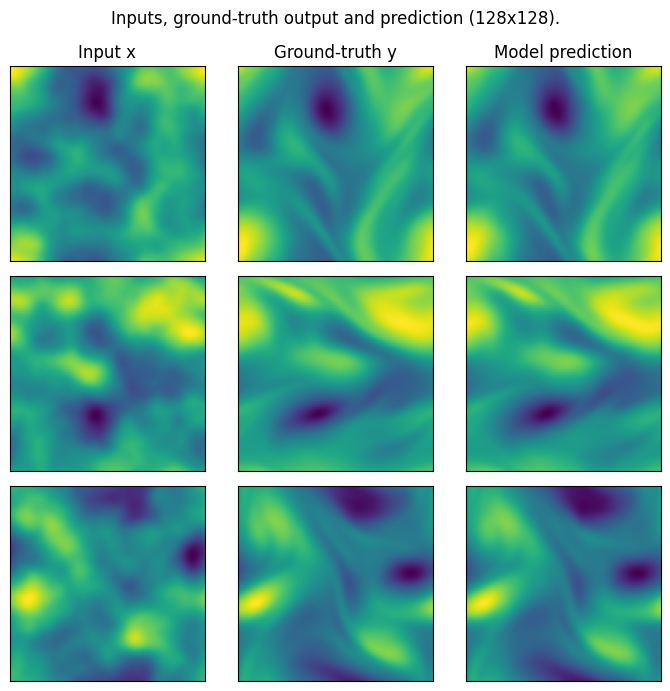

In [28]:
# load trained model
model_use = model
# model_use = model_reload

test_samples = test_loaders[128].dataset

fig = plt.figure(figsize=(7, 7))

for index in range(3):

    data = test_samples[index]
    data = data_processor.preprocess(data, batched=False)
    # input x
    x = data['x']
    print(x.shape)
    #  ground-truth y
    y = data['y']
    print(y.shape)
    # model prediction 

    out = model_use(x)
    print(out.shape)

    ax = fig.add_subplot(3, 3, index*3 + 1)
    ax.imshow(x[0][0])
    if index == 0:
        ax.set_title('Input x')
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(3, 3, index*3 + 2)
    ax.imshow(y.squeeze())
    if index == 0:
        ax.set_title('Ground-truth y')
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(3, 3, index*3 + 3)
    ax.imshow(out.squeeze().detach().numpy())
    if index == 0:
        ax.set_title('Model prediction')
    plt.xticks([], [])
    plt.yticks([], [])

fig.suptitle('Inputs, ground-truth output and prediction (128x128).', y=0.98)
plt.tight_layout()
plt.show()